# CISC455 Final Project - Convolutional Neural Networks Optimization using Genetic Algorithm

Pretrained Part

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from PIL import Image
import pandas as pd
import copy
%matplotlib inline
print("finished loading")

finished loading


In [ ]:
from google.colab import drive # get the access from google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/a3_train' # load image from google drive
os.chdir(path)

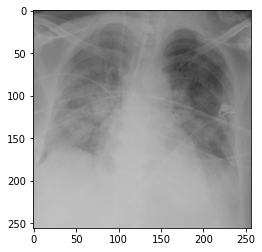

In [ ]:
train_img = Image.open('111.png').resize((256, 256))
plt.imshow(train_img, "gray")
plt.show()

In [ ]:
train_img_arr = np.array(train_img)
train_img_arr.shape

(256, 256, 3)

In [ ]:
y_train = pd.read_csv("/content/drive/MyDrive/y_train_covid.csv")["infection"]
y_train

0      1
1      1
2      1
3      0
4      1
      ..
482    1
483    1
484    1
485    1
486    1
Name: infection, Length: 487, dtype: int64

In [ ]:
print(os.listdir(path))

['1.png', '101.png', '100.png', '0.png', '10.png', '106.png', '102.png', '120.png', '110.png', '107.png', '109.png', '123.png', '12.png', '104.png', '117.png', '103.png', '111.png', '114.png', '105.png', '116.png', '119.png', '121.png', '115.png', '112.png', '118.png', '113.png', '108.png', '11.png', '122.png', '128.png', '134.png', '136.png', '135.png', '125.png', '139.png', '137.png', '13.png', '132.png', '126.png', '124.png', '131.png', '127.png', '129.png', '133.png', '130.png', '138.png', '161.png', '145.png', '162.png', '146.png', '147.png', '142.png', '155.png', '158.png', '140.png', '141.png', '15.png', '160.png', '153.png', '144.png', '159.png', '149.png', '148.png', '157.png', '14.png', '154.png', '16.png', '143.png', '150.png', '151.png', '152.png', '156.png', '164.png', '168.png', '166.png', '176.png', '182.png', '173.png', '170.png', '175.png', '178.png', '167.png', '189.png', '188.png', '179.png', '165.png', '184.png', '18.png', '171.png', '163.png', '177.png', '172.png',

In [ ]:
y_lab = np.array(y_train).reshape(1,-1)
y_lab

array([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 

In [ ]:
y_lab.shape

(1, 487)

In [ ]:
negative, positive = np.bincount(y_train)
class_0_weight = (1 / negative)*(negative + positive)/2.0 # scaling by total labels/2 suggested in the official document 
class_1_weight = (1 / positive)*(negative + positive)/2.0

In [ ]:
class_weight = [class_0_weight, class_1_weight]
class_weight

[1.512422360248447, 0.7469325153374233]

In [ ]:
def sort(file):
  inidi = int(file.split(".")[0])
  return inidi

In [ ]:
def load_data(cur_dir, width, height, y_lab):
  data = torch.empty(0, 3, width, height)
  labels = torch.empty(0)
  sorted_path = sorted([file for file in os.listdir(cur_dir)], key=sort)
  for ind, f in enumerate(sorted_path):
    crop = Image.open(f).convert('RGB').resize((256, 256))
    crop = np.array(crop, dtype=np.float32)
    crop = crop / 255.
    print("file: {}, shape: {}".format(f, crop.shape))
    print("file: {}, max: {}, min: {}".format(f, np.max(crop), np.min(crop)))
    crop = torch.from_numpy(crop)
    crop = np.transpose(crop,(2,1,0))
    print("reshape: ", crop.shape)
    crop = crop.reshape(1, *crop.shape)
    label = y_lab[0][ind]
    label = torch.Tensor([int(label)])
    data = torch.cat((data, crop), dim=0)
    labels = torch.cat((labels, label))
  return data, labels

In [ ]:
cur_dir = path
width = 256
height = 256
x_train, x_lab = load_data(cur_dir, width, height, y_lab)

In [ ]:
x_train.shape, x_lab.shape

(torch.Size([487, 3, 256, 256]), torch.Size([487]))

In [ ]:
torch.save(x_train, "/content/drive/MyDrive/train_images455.pt")
torch.save(x_lab, "/content/drive/MyDrive/train_labels455.pt")

In [ ]:
x_train = torch.load("/content/drive/MyDrive/train_images455.pt")
x_lab = torch.load("/content/drive/MyDrive/train_labels455.pt")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
x_train = x_train.to(device)
x_lab = x_lab.to(device)

In [ ]:
class getID(Dataset):
	def __init__(self, total_len):
		self.tmp = total_len
		self.total_len = self.tmp
	
	def __len__(self):
		return self.total_len
	
	def __getitem__(self, ind):
		return torch.Tensor([ind])

In [ ]:
total_len = x_train.shape[0]
total_len

487

In [ ]:
def get_train_val(train_ratio, total_len):
  torch.manual_seed(1)
  train_num = math.ceil(total_len * train_ratio)
  train_set, val_set = random_split(getID(total_len), lengths=(train_num, total_len - train_num))
  return train_set, val_set

In [ ]:
train_set, val_set = get_train_val(0.80, total_len)

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, num_workers=0, shuffle=True, drop_last=True)
print(len(train_loader))

12


In [ ]:
val_loader = DataLoader(val_set, batch_size=32, num_workers=0, shuffle=True, drop_last=True)
print(len(val_loader))

3


In [ ]:
from torchvision import models
import torch.nn as nn
def set_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = False

In [ ]:
model_ft = models.vgg16(pretrained=True)
set_parameter_requires_grad(model_ft)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,2)
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def initializae_network(single_pop, num_classes):
  '''
  This function is for initializing the network given the parameters
  single_pop: single parent in total_pop
  num_classes: number of classes for the task
  '''
  net = MyClassifier(single_pop, num_classes)
  return net


In [ ]:
def compute_loss(model, optimizer, images, target, loss_fn, train_mode):

  predicted = model(images)
  #print(predicted)
  #predicted_lab = torch.argmax(predicted, dim=1).float()
  #print(predicted)
  loss = loss_fn(predicted, target.long())

  if train_mode:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
  else:
      return loss.item(), torch.argmax(predicted, dim=1).float()

  return loss.item()

In [ ]:
def train(net, train_ind, train_img, train_lab, val_ind, optimizer, epochs, lr, weights):
  loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(weights).to(device), reduction="mean")
  lowest_loss = np.inf
  total_val_acc = []
  for epoch in range(epochs):
    net.zero_grad()
    loss = 0
    #net.train()
    for batch_idx in train_ind:
        net.train()
        #optimizer.zero_grad()
        batch_idx = batch_idx.view(-1).long()
        image_batch, label_batch = train_img[batch_idx], train_lab[batch_idx]
        train_loss = compute_loss(net, optimizer, image_batch, label_batch, loss_fn, train_mode=True)
        loss += train_loss

    loss /= len(train_ind)
    print("epoch: {}, train loss: {}".format(epoch+1, loss))
    loss_eval = 0

    #net.eval()
    with torch.no_grad():
      net.eval()
      actual_labels = torch.empty(0).long()
      predicted_labels = torch.empty(0).float()
      for batch_idx in val_ind:
          batch_idx = batch_idx.view(-1).long()
          image_batch, label_batch = train_img[batch_idx], train_lab[batch_idx]
          #print("val_ind: ", label_batch)
          actual_labels = torch.cat((actual_labels, label_batch.cpu()))
          eval_loss, predicted = compute_loss(net, optimizer, image_batch, label_batch, loss_fn, train_mode=False)
          predicted_labels = torch.cat((predicted_labels, predicted.cpu()))
          #print("val_ind predict: ", predicted)
          #val_acc = torch.sum(torch.squeeze(predicted).float() == all_label).item() / float(all_label.size()[0])
          loss_eval += eval_loss
      loss_eval /= len(val_ind)
      val_acc = torch.sum(predicted_labels == actual_labels).item() / len(actual_labels)
      total_val_acc.append(val_acc)
      print("eval loss: ", loss_eval)
      print("validation accuracy: ", val_acc)
  return np.mean(total_val_acc)

In [ ]:
import time
lr = 0.0005
optimizer = torch.optim.Adam(model_ft.parameters(), lr=lr)
epochs = 20
start = time.time()
val_acc = train(model_ft.to(device), train_loader, x_train, x_lab, val_loader, optimizer, epochs, lr, class_weight)
used = time.time()-start
print("training time: ", used)
print(val_acc)

epoch: 1, train loss: 0.6948675662279129
eval loss:  0.7034751176834106
validation accuracy:  0.3958333333333333
epoch: 2, train loss: 0.6520494620005289
eval loss:  0.6404335896174113
validation accuracy:  0.7291666666666666
epoch: 3, train loss: 0.6173509582877159
eval loss:  0.6222799817721049
validation accuracy:  0.6666666666666666
epoch: 4, train loss: 0.5917341684301695
eval loss:  0.6177941163380941
validation accuracy:  0.71875
epoch: 5, train loss: 0.5747624610861143
eval loss:  0.6111293236414591
validation accuracy:  0.7083333333333334
epoch: 6, train loss: 0.5524620339274406
eval loss:  0.5951898892720541
validation accuracy:  0.7291666666666666
epoch: 7, train loss: 0.5301657468080521
eval loss:  0.6170672376950582
validation accuracy:  0.7083333333333334
epoch: 8, train loss: 0.5402769943078359
eval loss:  0.5962462226549784
validation accuracy:  0.7395833333333334
epoch: 9, train loss: 0.5547492156426111
eval loss:  0.6318174799283346
validation accuracy:  0.70833333333